# Udacity nd025 Blog Project
## Idea: Have a look at the Airbnb listings and get a better understanding of hosts and ratings.
1. What influences average review scores?
1. Superhost and hosts: In what way are they different?
  * Do their review scores differ?
  * Which amneties are offered?
  * Are superhosts super-expensive?
3. What influences the superhost staus?

In [116]:
# Import the neccessary libraries

import pandas as pd
import shap
import datetime as dt
import glob
import seaborn as sns
%matplotlib inline

# Load all listing csv-files from the data directory 
files = glob.glob('./data/' + '*_listings.csv')
raw_listings = pd.concat(map(pd.read_csv, files))

What are the columns of the dataframe?

In [117]:
raw_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

There are quite a few colums about the hosts and their offers. Let's have a look at them. 


In [118]:
host_columns = ['host_since', 'host_about', 'host_response_time', 'host_response_rate', 'host_listings_count', 'host_is_superhost',
                'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'review_scores_rating', 'require_guest_profile_picture', 'require_guest_phone_verification','reviews_per_month'] 
offers_columns = ['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price',
                  'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights','maximum_nights']

hosts = raw_listings[host_columns].copy()
offers = raw_listings[offers_columns].copy()

In [119]:
hosts.head()

,host_since,host_about,host_response_time,host_response_rate,host_listings_count,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,review_scores_rating,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,2015-04-15,We are country and city connecting in our deck...,NaN,NaN,1.0,f,"['email', 'phone', 'facebook', 'reviews']",t,f,NaN,f,f,NaN
1,2012-06-07,I live in Boston and I like to travel and have...,within an hour,100%,1.0,f,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,94.0,f,f,1.30
2,2009-05-11,"I am a middle-aged, single male with a wide ra...",within a few hours,100%,1.0,t,"['email', 'phone', 'reviews', 'jumio']",t,t,98.0,t,f,0.47
3,2013-04-21,My husband and I live on the property. He’s a...,within a few hours,100%,1.0,f,"['email', 'phone', 'reviews']",t,f,100.0,f,f,1.00
4,2014-05-11,I work full time for a public school district....,within an hour,100%,1.0,t,"['email', 'phone', 'reviews', 'kba']",t,t,99.0,f,f,2.25


In [120]:
hosts.dtypes

host_since                           object
host_about                           object
host_response_time                   object
host_response_rate                   object
host_listings_count                 float64
host_is_superhost                    object
host_verifications                   object
host_has_profile_pic                 object
host_identity_verified               object
review_scores_rating                float64
require_guest_profile_picture        object
require_guest_phone_verification     object
reviews_per_month                   float64
dtype: object

In [121]:
hosts.isna().mean()

host_since                          0.000270
host_about                          0.292854
host_response_time                  0.134270
host_response_rate                  0.134270
host_listings_count                 0.000270
host_is_superhost                   0.000270
host_verifications                  0.000000
host_has_profile_pic                0.000270
host_identity_verified              0.000270
review_scores_rating                0.197217
require_guest_profile_picture       0.000000
require_guest_phone_verification    0.000000
reviews_per_month                   0.186816
dtype: float64

The host columns contain many non-numerical features that must be taken care of. Most columns contain just a few or even no NaN values. That's fine.

Let's have a look at the offers now.

In [122]:
offers.head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights
0,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,$35.00,1,$0.00,2,1125
1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$65.00,$95.00,$10.00,0,$0.00,2,15
2,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",NaN,$65.00,NaN,NaN,1,$20.00,3,45
3,House,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$75.00,$100.00,$50.00,2,$25.00,1,1125
4,House,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",NaN,$79.00,NaN,$15.00,1,$0.00,2,31


In [123]:
offers.dtypes

property_type        object
room_type            object
accommodates          int64
bathrooms           float64
bedrooms            float64
beds                float64
bed_type             object
amenities            object
square_feet         float64
price                object
security_deposit     object
cleaning_fee         object
guests_included       int64
extra_people         object
minimum_nights        int64
maximum_nights        int64
dtype: object

In [124]:
offers.isna().mean()

property_type       0.000540
room_type           0.000000
accommodates        0.000000
bathrooms           0.004052
bedrooms            0.002161
beds                0.001351
bed_type            0.000000
amenities           0.000000
square_feet         0.979333
price               0.000000
security_deposit    0.566662
cleaning_fee        0.288667
guests_included     0.000000
extra_people        0.000000
minimum_nights      0.000000
maximum_nights      0.000000
dtype: float64

Quite similar to the hosts data. A few missing values and also some non-numerical features.
The cleaning of the data can begin.

## Cleaning the data
Things neccessary to clean the hosts' data:

* Rows without *review_scores_rating* are not useful if the review score should be predicted => Drop them.
* *host_since* is a date. Create a new colum host_since_in_days and drop host_since
* In this context it's only interesting whether hosts made a *host_about* statement or not.
* *host_verifications* contains lists of categorical features that needs to be split and converted into dummy/indicator variable.
* *host_is_superhost*, *host_has_profile_pic*, *host_identity_verified*, *require_guest_profile_picture*, *require_guest_phone_verification*: Replace t with 1 and f with 0.
* *host_response_time*, *host_response_rate*: Drop rows where it's missing to be on the safe side.
* *host_response_time* is a categorical feature that needs to be converted into dummy/indicator variable.
* *host_response_rate* must be converted from string to float

Steps for cleaning the offers' data:

* *property_type*, *room_type* and *bed_type* are categorical features that need to be converted into dummy/indicator variable.
* *amenities* contains lists of categorical features that needs to be split and converted into dummy/indicator variable.
* *square_feet* would be interesting, but unfortunately the value is missing in 98% of the rows => Drop the column.
* *security_deposit*, *cleaning_fee*, *extra_people* and *price* must be converted from string to float
* *security_deposit* and *cleaning_fee* have NaN values that presumably indicate that no fee / deposit is required. Replace these by 0.

In [125]:
hosts_and_offers = pd.concat([offers, hosts], axis=1)

# Drop rows without a review_scores_rating
hosts_and_offers.dropna(subset='review_scores_rating', inplace=True)

# Replace host_since with host_since_in_days
hosts_and_offers['host_since_in_days'] = (dt.datetime.today() - pd.to_datetime(hosts_and_offers['host_since'])).dt.days
hosts_and_offers.drop(columns='host_since', inplace=True)

# Set host_about to 1 if the host left a statement, 0 otherwise
hosts_and_offers.host_about.fillna(0, inplace=True)
hosts_and_offers['host_about'].where(hosts_and_offers['host_about'] == 0, 1, inplace=True)
hosts_and_offers['host_about'] = hosts_and_offers['host_about'].astype(int)


# Perform a one-hot-encoding with the different kinds of verification 
hosts_and_offers['host_verifications'] = hosts_and_offers['host_verifications'].str.replace(r'[\'\[\],]', '',regex=True).str.split()
hosts_and_offers = hosts_and_offers.drop('host_verifications', axis=1).join(
                                                                                pd.get_dummies(
                                                                                                pd.DataFrame(hosts_and_offers.host_verifications.tolist()).stack(), prefix='host'
                                                                                                ).astype(int).groupby(level=0).sum()
                                                                             )

mapping = {'t': 1, 'f': 0}
hosts_and_offers['host_is_superhost'] = hosts_and_offers['host_is_superhost'].map(mapping)
hosts_and_offers['host_has_profile_pic'] = hosts_and_offers['host_has_profile_pic'].map(mapping)
hosts_and_offers['host_identity_verified'] = hosts_and_offers['host_identity_verified'].map(mapping)
hosts_and_offers['require_guest_profile_picture'] = hosts_and_offers['require_guest_profile_picture'].map(mapping)
hosts_and_offers['require_guest_phone_verification'] = hosts_and_offers['require_guest_phone_verification'].map(mapping)

# Drop rows without a response
hosts_and_offers.dropna(subset=['host_response_time', 'host_response_rate'], inplace=True)

# Encode host_response_time
hosts_and_offers = pd.get_dummies(hosts_and_offers, columns=['host_response_time'])

# Convert to float
hosts_and_offers['host_response_rate'] = hosts_and_offers['host_response_rate'].str.replace('%','').astype(float)


# Encode 'property_type', 'room_type', 'bed_type'
hosts_and_offers = pd.get_dummies(hosts_and_offers, columns=['property_type', 'room_type', 'bed_type'])


# Perform a one-hot-encoding with the different kinds of amenities 
hosts_and_offers['amenities'] = hosts_and_offers['amenities'].str.replace(r'[\{\}\"]', '',regex=True).str.split(',')
hosts_and_offers = hosts_and_offers.drop('amenities', axis=1).join(
                                                                    pd.get_dummies(
                                                                                    pd.DataFrame(hosts_and_offers.amenities.tolist()).stack(), prefix='amnety'
                                                                                    ).astype(int).groupby(level=0).sum()
                                                                    )

hosts_and_offers.drop(columns=['square_feet'], inplace=True)

# Convert to float
hosts_and_offers['security_deposit'] = hosts_and_offers['security_deposit'].str.replace(r'[$.,]','', regex=True).astype(float) / 100
hosts_and_offers['cleaning_fee'] = hosts_and_offers['cleaning_fee'].str.replace(r'[$.,]','', regex=True).astype(float) / 100
hosts_and_offers['extra_people'] = hosts_and_offers['extra_people'].str.replace(r'[$.,]','', regex=True).astype(float) / 100
hosts_and_offers['price'] = hosts_and_offers['price'].str.replace(r'[$.,]','', regex=True).astype(float) / 100

# Replace security_deposit and cleaning_fee NaN's by 0
hosts_and_offers['security_deposit'].fillna(0, inplace=True)
hosts_and_offers['cleaning_fee'].fillna(0, inplace=True)

hosts_and_offers.reset_index(drop=True, inplace=True)

Are there any NaN values left?

In [126]:
hosts_and_offers.columns[hosts_and_offers.isna().mean()>0]

Index(['bathrooms', 'bedrooms', 'beds'], dtype='object')

*bathrooms*, *bedrooms* and *beds* still have NaN values. Replace them by 0 to indicate that they are not offered.

In [127]:
hosts_and_offers.fillna(0, inplace=True)

Last check:

In [128]:
hosts_and_offers.dtypes.value_counts()

int64      71
uint8      31
float64    11
dtype: int64

In [129]:
hosts_and_offers.isna().sum().sum()

0

In [130]:
hosts_and_offers.shape

(5411, 113)

All features are numeric, no missing values anymore. The ML part can start now.

## Predicting the rating
We have tabular data consisting of 5411 rows and 113 columns and want to predict the *review_scores_rating* column. [XGBoost](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/) is good choice for such a task. Documentation of the XGBoost library can be found [here](https://xgboost.readthedocs.io/en/stable/).

In [131]:
# Import the stuff neccessary for the ML part

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
import xgboost as xgb
from scipy.stats import uniform, randint


# Define the feature matrix and the lables
X, y = hosts_and_offers.drop(columns='review_scores_rating'), hosts_and_offers['review_scores_rating']

# Split the data into a training and test set. Use 10 % of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Instantiate the model
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Define a set of some hyperparameters with ranges in which RandomizedSearchCV will look for the best values.
# https://xgboost.readthedocs.io/en/stable/parameter.html
parameters = {
                "colsample_bytree": uniform(0.7, 0.3),
                "gamma": uniform(0, 0.5),
                "learning_rate": uniform(0.03, 0.3),
                "max_depth": randint(2, 6),
                "n_estimators": randint(100, 150),  
                "subsample": uniform(0.6, 0.4)
            }

# Search for the best model
best_model = RandomizedSearchCV(model, param_distributions=parameters, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=-1, return_train_score=True)

# Fit the data
best_model.fit(X, y)

print(best_model.best_estimator_.get_params())

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/Users/dirk/Anaconda/anaconda3/envs/AI/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/dirk/Anaconda/anaconda3/envs/AI/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/dirk/Anaconda/anaconda3/envs/AI/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/dirk/Anaconda/anaconda3/envs/AI/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and wi

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.722213395520227, 'enable_categorical': False, 'gamma': 0.1792328642721363, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.06476071785753891, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 108, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8493192507310232, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [132]:
# Use the model to predict the ratings of the test data
y_hat = best_model.predict(X_test)

# See how good the model is
mse = mean_squared_error(y_test, y_hat)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 35.9521


## Analysis
I'll use the SHAP library to evaluate feature importances etc.
* https://christophm.github.io/interpretable-ml-book/shap.html
* https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27


In [143]:
def plot_beeswarm(values):
    '''
    This function plot a beeswarm diagram of the provided shap values

    input:
        values: shap values of the explainer of the feature matrix

    output:
        beeswarm plot of the data
    '''

    return shap.plots.beeswarm(shap_values)

In [133]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(best_model.best_estimator_)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


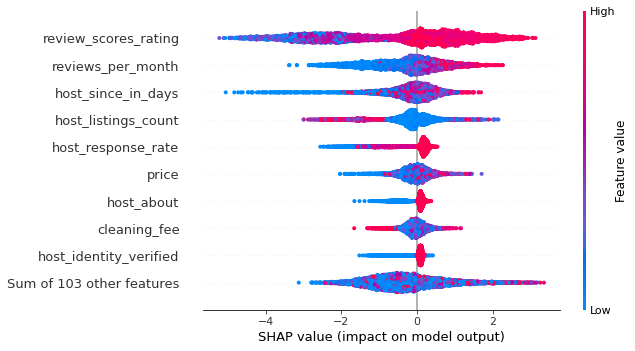

In [145]:
plot_beeswarm(shap_values)

The SHAP beeswarm plot above shows the most relevant features and their influence on the model's result. The four most relevant features that affect the review_scores_rating feature in this model are.
1. host_listings_count
1. host_is_superhost
1. host_response_rate
1. price 

What does *host_is_superhost* mean? Why does it influence the rating calculated by the model? Let's have a deeper look into that feature.


### Superhosts

This is a great example why business / real word knowledge is important. In the model the feature *host_is_superhost* influences the rating, but if we look at AirBnB's definition of superhost we learn something different.

AirBnB about superhosts:

> "Anyone who’s extremely welcoming and experienced at making guests feel like they belong, or anyone who can conjure up an extraordinary Airbnb Experience can become a Superhost.
> No need to apply—you simply earn Superhost status by **doing things like receiving positive reviews, being responsive, and avoiding cancellations** where possible." 

In reality the relationship between rating and being a superhost has the opposite direction.
* Model:   superhost --> rating
* Reality: rating --> superhost

#### Do superhosts's ratings differ from other hosts' ratings?
A distribution plot or historgram will show some details.

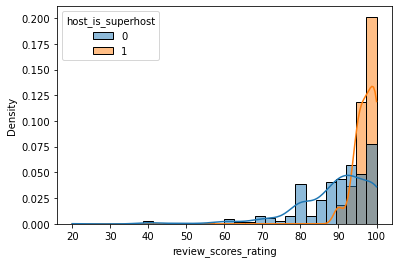

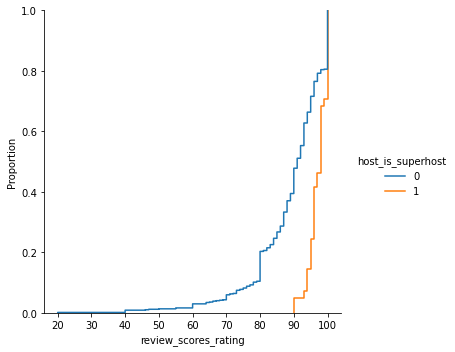

In [135]:
data = hosts_and_offers[(hosts_and_offers.host_listings_count >15)]

#To compare the distribution of subsets that differ substantially in size, use indepdendent density normalization
#https://seaborn.pydata.org/generated/seaborn.histplot.html
sns.histplot(data=data, x="review_scores_rating", kde=True, hue='host_is_superhost', stat="density", common_norm=False);
sns.displot(data=data, x="review_scores_rating", hue='host_is_superhost', kind='ecdf');

We can see that the ratings of superhosts are centered in the range 90 to 100. That supports AirBnB's explaination that the status is earned by postive reviews.

#### Amneties offered by superhosts
To see differences between superhosts and others hosts we take a look at the amneties offered by them.

In [136]:
# Define two subsets of the data
superhosts = hosts_and_offers[(hosts_and_offers.host_is_superhost == 1)]
not_superhosts = hosts_and_offers[(hosts_and_offers.host_is_superhost == 0)]

# The amnity columns are binary. So the mean will be the percentage an amnety is offered. 
diff_amneties = pd.concat([pd.DataFrame(columns=['Superhosts'], data=superhosts.filter(like='amnety').mean()),
                           pd.DataFrame(columns=['Non-superhosts'], data=not_superhosts.filter(like='amnety').mean())], axis=1)

# Compute the difference between the two classes
diff_amneties['Diff'] = (diff_amneties['Superhosts'] - diff_amneties['Non-superhosts']) * 100

# Make the table pretty
diff_amneties.index = diff_amneties.index.str.replace('amnety_', '')
diff_amneties.index.name = 'Amnety'
diff_amneties.sort_values(by='Diff', ascending=False)[:10].style.format({
                                                            'Superhosts': '{:,.2%}'.format,
                                                            'Non-superhosts': '{:,.2%}'.format,
                                                            'Diff': '{:,.2f} pp'.format,
                                                        })

,Superhosts,Non-superhosts,Diff
Amnety,,,
Laptop Friendly Workspace,37.64%,34.65%,2.99 pp
Fire Extinguisher,56.59%,54.17%,2.42 pp
Free Parking on Premises,41.16%,39.51%,1.65 pp
First Aid Kit,39.53%,37.95%,1.58 pp
Iron,38.00%,36.46%,1.53 pp
Essentials,86.46%,85.15%,1.31 pp
Pets live on this property,19.04%,17.80%,1.24 pp
Indoor Fireplace,17.96%,16.80%,1.16 pp
Dog(s),11.10%,9.97%,1.13 pp


In [137]:
# lower end of the table
diff_amneties.sort_values(by='Diff', ascending=False)[-10:].style.format({
                                                            'Superhosts': '{:,.2%}'.format,
                                                            'Non-superhosts': '{:,.2%}'.format,
                                                            'Diff': '{:,.2f} pp'.format,
                                                        })

,Superhosts,Non-superhosts,Diff
Amnety,,,
Pets Allowed,14.08%,14.64%,-0.56 pp
Washer,73.29%,73.86%,-0.57 pp
Safety Card,17.06%,18.20%,-1.14 pp
Wheelchair Accessible,6.23%,7.51%,-1.28 pp
Pool,4.87%,6.30%,-1.42 pp
Doorman,3.61%,5.58%,-1.97 pp
Gym,11.19%,13.50%,-2.31 pp
Air Conditioning,48.92%,51.50%,-2.58 pp
Family/Kid Friendly,53.07%,55.87%,-2.80 pp


A laptop friendly workspace, fire extinguishers and free parking on premises are amneties offered slightly more often by superhosts.

Air conditioning, a family/kid friendly environment and elevators are offered slightly more often by non-superhosts.


#### Does superhost mean super expensive? 
To answer that question we put the listings in five bins representing price ranges of the offers. 

In [138]:
# Create a dataframe with the data to analyze
df = hosts_and_offers[['review_scores_rating', 'host_is_superhost', 'price']].copy()

# Add a column 'price range' showing the price range for each columns
df['price range'] = pd.qcut(x=df['price'], q=5)

# Create a dataframe that contains the number of liststings in each group
count = pd.DataFrame(pd.value_counts(df['price range']))
count.rename(columns={'price range': 'Number of listings'}, inplace=True)

# Rename a few columns and group by price range
df.rename(columns={'review_scores_rating': 'Average rating', 'host_is_superhost': 'Share of superhosts'}, inplace=True)
df = df.groupby(by='price range').mean().drop('price', axis=1)

# Attach the count dataframe
df = pd.concat([df, count], axis=1)

# Make the table pretty
df.index.name='Price range'
df.style.format({
                    'Average rating': '{:,.2f}'.format,
                    'Share of superhosts': '{:,.0%}'.format,
                })

,Average rating,Share of superhosts,Number of listings
Price range,,,
"(10.999, 70.0]",92.34,18%,1126
"(70.0, 99.0]",93.71,25%,1139
"(99.0, 139.0]",93.69,23%,999
"(139.0, 200.0]",93.56,19%,1157
"(200.0, 1300.0]",93.49,18%,990


We see that in all bins 18 to 25 percent of the hosts are superhosts. So regardless of the amount of money you want to spend a superhost can be found.


After learning all this about superhosts, the question comes up whether we are able to predict the superhost status. Let' create a new model - this time for classification - to test this.

In [139]:

X, y = hosts_and_offers.drop(columns='host_is_superhost'), hosts_and_offers['host_is_superhost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False ,random_state=42, eval_metric='mlogloss')

model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [140]:
y_hat = model.predict(X_test)

print(confusion_matrix(y_test, y_hat))
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_hat)))

[[431   0]
 [  0 111]]
XGBoost model accuracy score: 1.0000


An accuracy of 100% is alarming, but I do not see any mistakes in the code. If AirBnB computes the superhost status from these features, can that be a reason for the model learnig this computation? Any other ideas?

In [141]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Let's create a beeswarm plot again.

#### Does the model support AirBnB's explaination of the superhost status?

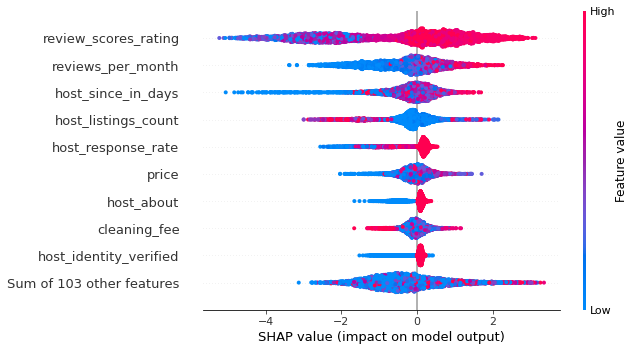

In [146]:
plot_beeswarm(shap_values)

In the model the most important features to predict the superhost status are

1. *review_scores_rating*
1. *reviews_per_month*
1. *host_since_in_days*
1. *host_listings_count*
1. *response_rate*

We can see that many ratings, high scores, and a high response rate improve the chance of becoming a superhosts. That fully matches AirBnB's explaination.